Imports

In [103]:
%run Data_Analysis_Functions.ipynb

#### Read all files and check the dfs

In [104]:
import numpy as np

path = '../DataLogs' 
test = 'TestInf'

In [105]:
import pandas as pd

In [106]:
# Read in all the data
households = pd.read_csv(f"{path}/Households.csv").sort_index(axis=1)
cons_firms = pd.read_csv(f"{path}/Consumer_Firms.csv").sort_index(axis=1)
cap_firms = pd.read_csv(f"{path}/Capital_Firms.csv").sort_index(axis=1)
pboard = pd.read_csv(f"{path}/Public_Info_Board.csv").sort_index(axis=1)
bank = pd.read_csv(f"{path}/Bank.csv").sort_index(axis=1)

Calculate number of agents to do a sense check

In [107]:
mask = households['date'].apply(lambda x: np.isnan(x) if isinstance(x, float) else False)

# filter dataframe using mask
filtered_df = households[mask]

timestep = int(households['date'].max())
#timestep = 15
n_households = households[households.date == 0].shape[0]
n_cons_firms = cons_firms[cons_firms.date == 0].shape[0]
n_cap_firms = cap_firms[cap_firms.date == 0].shape[0]
t = np.linspace(0,timestep, timestep +1) 
print(f"Program has {n_households} households, {n_cons_firms} consumer firms, {n_cap_firms} capital firms, and runs for {timestep} timesteps")

Program has 200 households, 36 consumer firms, 12 capital firms, and runs for 200 timesteps


Get sums and averages for each timestep

In [108]:
households_sum = households.groupby('date').sum().reset_index()
households_avg = households.groupby('date').mean().reset_index()
cons_firms_sum = cons_firms.groupby('date').sum().reset_index()
cons_firms_avg = cons_firms.groupby('date').mean().reset_index()
cap_firms_sum = cap_firms.groupby('date').sum().reset_index()
cap_firms_avg = cap_firms.groupby('date').mean().reset_index()

# Separate households into workers or firm owners and caclulate sums and averages
# Get id of households who are firm owners
firm_owner_ids = households[(households['date'] == 0) & (households['firm_owner'] == 1)]['id'].tolist()
households_workers = households[~households['id'].isin(firm_owner_ids)]
households_owners = households[households['id'].isin(firm_owner_ids)]

households_workers_avg = households_workers.groupby('date').mean().reset_index()
households_workers_sum = households_workers.groupby('date').sum().reset_index()
households_owners_avg = households_owners.groupby('date').mean().reset_index()
households_owners_sum = households_owners.groupby('date').sum().reset_index()

# Calculate the average of incomes for the firm owners appropriately
n_firm_owners = n_cap_firms + n_cons_firms
firm_owner_sum = households_owners.groupby('date')['firm_owner'].sum()
households_owners_avg.loc[:, 'income_dividend_average'] = households_owners.groupby('date')['income_dividend'].sum() / firm_owner_sum.values
households_owners_avg.loc[:, 'income_wage_average'] = households_owners.groupby('date')['income_wage'].sum() / (n_firm_owners - firm_owner_sum.values)

Minor data fixes

In [109]:
bank["cons_inflation_current"] = bank["cons_inflation_current"] - 1


In [110]:
# correctly calculate bankruptcies
pboard["bankruptcies"] = (pboard["p_bankrupt_cons_firms"] * n_cons_firms + pboard["p_bankrupt_cap_firms"] * n_cap_firms) / (n_cons_firms + n_cap_firms)

Delete the original dataframes to free memory (we use the avg and sums)

In [111]:
del households
del cons_firms
del cap_firms

Copy sector data to separate dataframe

In [112]:
sector_data = pd.DataFrame({'date': t})

sector_data = pd.concat([sector_data, pboard.filter(regex='actual_spending_on_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='planned_spending_on_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='actual_production_on_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='planned_production_on_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='inventory_by_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='quantity_sold_by_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='total_cons_emissions_by_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='total_firm_emissions_by_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='offsets_sold_by_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='price_level_cons_sector')], axis=1 )


for i in range(12):
    sector_data[f"real_spending_on_sector_{i}"] = sector_data[f"actual_spending_on_sector_{i}"] / sector_data[f"price_level_cons_sector_{i}"]
    sector_data[f"real_spending_growth_on_sector_{i}"] = sector_data[f"real_spending_on_sector_{i}"].pct_change()

for i in range(12):
    sector_data[f"average_unit_emissions_by_sector_{i}"] = sector_data[f"total_cons_emissions_by_sector_{i}"] / sector_data[f"inventory_by_sector_{i}"]

Calculate new useful sector data

In [113]:
for i in range (0,12):
    sector_data[f"actual_spending_on_sector_{i}_real"] = sector_data[f"actual_spending_on_sector_{i}"] / sector_data[f"price_level_cons_sector_{i}"]
    sector_data[f"planned_spending_on_sector_{i}_real"] = sector_data[f"planned_spending_on_sector_{i}"] / sector_data[f"price_level_cons_sector_{i}"]

Drop sector columns from public board, and store aggreagate data

In [114]:
pboard = pboard.drop(columns=pboard.filter(regex='actual_spending_on_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='planned_spending_on_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='actual_production_on_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='planned_production_on_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='inventory_by_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='quantity_sold_by_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='total_cons_emissions_by_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='total_firm_emissions_by_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='offsets_sold_by_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='price_level_cons_sector').columns)

actual_spending = sector_data.filter(regex='actual_spending_on_sector')
pboard['total_actual_spending'] = actual_spending.sum(axis=1)
planned_spending = sector_data.filter(regex='planned_spending_on_sector')
pboard['total_planned_spending'] = planned_spending.sum(axis=1)
pboard = pboard.drop(columns=pboard.filter(regex='planned_spending_on_sector').columns)
inventory = sector_data.filter(regex='inventory_by_sector')
pboard['total_inventory'] = inventory.sum(axis=1)
planned_production = sector_data.filter(regex='planned_production_on_sector')
pboard['total_planned_production'] = planned_production.sum(axis=1)
actual_production = sector_data.filter(regex='actual_production_on_sector')
pboard['total_actual_production'] = actual_production.sum(axis=1)
quantity_sold = sector_data.filter(regex='quantity_sold_by_sector')
pboard['total_quantity_sold'] = quantity_sold.sum(axis=1)
total_cons_emissions = sector_data.filter(regex='total_cons_emissions_by_sector')
pboard['total_cons_emissions'] = total_cons_emissions.sum(axis=1)
total_firm_emissions = sector_data.filter(regex='total_firm_emissions_by_sector')
pboard['total_firm_emissions'] = total_firm_emissions.sum(axis=1)
offsets_sold = sector_data.filter(regex='offsets_sold_by_sector')
pboard['total_offsets_sold'] = offsets_sold.sum(axis=1)

Calculate other useful data for public board

In [115]:
pboard['cons_production_shortfall'] = pboard['total_planned_production'] - pboard['total_actual_production']
pboard['cap_production_shortfall'] = pboard['cap_goods_production_planned'] - pboard['cap_goods_production']

Calculate useful economic data and store these in the economy dataframe

In [116]:
economy = pd.DataFrame({'date': t})

# Total cons spending and growth , real and nominal
economy['cons_spending_nominal'] = pboard['total_actual_spending']
economy['cons_spending_real'] = pboard['total_actual_spending'] / pboard['price_level_current']

economy['cons_spending_growth_nominal'] = pboard['total_actual_spending'].pct_change() * 100
economy["cons_spending_growth_real"] = economy['cons_spending_real'].pct_change() * 100

# Cons sending shortfall
economy["cons_spending_shortfall"] = pboard["total_planned_spending"] - pboard["total_actual_spending"] 

# Capital Spending
economy['cap_spending_nominal'] = pboard['capital_spending']
economy['cap_spending_real'] = pboard['capital_spending'] / pboard['cap_price_level_current']

economy['cap_spending_growth_nominal'] = economy['cap_spending_nominal'].pct_change() * 100
economy['cap_spending_growth_real'] = economy['cap_spending_real'].pct_change() * 100

# Capital spending shortfall
economy["cap_spending_shortfall"] = pboard["machine_spending_planned"] - pboard["capital_spending"] 


# GDP Figures
economy['GDP_nominal'] = economy['cons_spending_nominal'] + economy['cap_spending_nominal'] + cap_firms_sum['tax_payments'] + cons_firms_sum['tax_payments']
economy['GDP_real'] = economy["cons_spending_real"] + economy['cap_spending_real'] + (cap_firms_sum['tax_payments'] + cons_firms_sum['tax_payments'])/pboard['price_level_current']

economy['GDP_growth_nominal'] = economy['GDP_nominal'].pct_change() * 100
economy['GDP_growth_real'] = economy['GDP_real'].pct_change() * 100


# set first growth figures to 0
economy.loc[:1, 'cons_spending_growth_nominal'] = 0
economy.loc[:1, 'cons_spending_growth_real'] = 0
economy.loc[:1, 'GDP_growth_nominal'] = 0
economy.loc[:1, 'GDP_growth_real'] = 0
economy.loc[:1, 'cap_spending_growth_nominal'] = 0
economy.loc[:1, 'cap_spending_growth_real'] = 0


## Plot the data

### Plot Households

In [117]:
# Find index where households_workers_avg["consumption_budget"] < 0 
households_workers_avg[households_workers_avg["consumption_budget"] < 0]

,date,c_excess_money,c_f,consumption_budget,emission_sensitivity_avg,firm_owner,id,income_average,income_current,income_dividend,income_unemployment_benefit,income_wage,reservation_wage,saving_propensity,saving_propensity_optimist,saving_propensity_pessimist,savings,savings_desired,sentiment,total_emissions,unemp_duration,unemp_duration_upper_bound,unemployed
130,130.0,0.3,0.5,-7.500000e-01,0.107417,0.0,100.921053,978.782895,1117.131579,0.0,0.000000,1117.131579,500.0,0.205921,0.2,0.3,3.212651e+09,1957.565789,0.940789,0.000000,0.000000,4.0,0.000000
135,135.0,0.3,0.5,-1.771711e+01,0.108413,0.0,100.921053,1060.769737,1199.407895,0.0,0.000000,1199.407895,500.0,0.207895,0.2,0.3,2.439476e+10,2121.539474,0.921053,0.000000,0.000000,4.0,0.000000
144,144.0,0.3,0.5,-3.710125e+03,0.109584,0.0,100.921053,1171.473684,1236.888158,0.0,0.000000,1236.888158,500.0,0.203289,0.2,0.3,9.378059e+11,2342.947368,0.967105,0.000000,0.000000,4.0,0.000000
150,150.0,0.3,0.5,-3.094053e+04,0.108202,0.0,100.921053,1175.888158,1198.059211,0.0,0.000000,1198.059211,500.0,0.205921,0.2,0.3,1.068219e+13,2351.776316,0.940789,0.000000,0.000000,4.0,0.000000
160,160.0,0.3,0.5,-9.013996e+05,0.105299,0.0,100.921053,990.092105,855.493421,0.0,108.552632,746.940789,500.0,0.228289,0.2,0.3,6.159890e+14,1980.184211,0.717105,1723.684211,1.263158,4.0,0.217105
161,161.0,0.3,0.5,-5.340495e+05,0.106152,0.0,100.921053,960.046053,845.802632,0.0,118.421053,727.381579,500.0,0.226974,0.2,0.3,9.239835e+14,1920.092105,0.730263,1721.052632,1.565789,4.0,0.236842
163,163.0,0.3,0.5,-4.461524e+05,0.107667,0.0,100.921053,893.328947,780.197368,0.0,125.000000,655.197368,500.0,0.229605,0.2,0.3,2.078963e+15,1786.657895,0.703947,1670.723684,1.500000,4.0,0.250000
169,169.0,0.3,0.5,-5.297514e+06,0.105734,0.0,100.921053,732.934211,691.453947,0.0,187.500000,503.953947,500.0,0.242105,0.2,0.3,2.368069e+16,1465.868421,0.578947,0.000000,3.000000,4.0,0.375000
171,171.0,0.3,0.5,-6.783885e+07,0.106388,0.0,100.921053,694.532895,673.368421,0.0,217.105263,456.263158,500.0,0.249342,0.2,0.3,5.328154e+16,1389.065789,0.506579,546.381579,4.263158,4.0,0.434211
172,172.0,0.3,0.5,-2.524096e+08,0.106290,0.0,100.921053,676.750000,645.875000,0.0,240.131579,405.743421,500.0,0.254605,0.2,0.3,7.992232e+16,1353.500000,0.453947,471.381579,4.842105,4.0,0.480263


Original worker households

All original Firm owners 

In [118]:
"""
cols_to_exclude = ['date', 
# characteristics:
                   "c_f", "c_excess_money", "consumption_propensity", 
                   "saving_propensity_optimist", "saving_propensity_pessimist", 
                   "unemp_duration_upper_bound", "emission_sensitivity_avg"

# irrelevant for firm owners: 
                    "Unemployed", "unemp_duration",
                    "income_current","income_unemployment_benefit",
                    "income_wage", "income_wage_average",
                    "firm_owner", "id"] 

plot_values_excl(f"{path}\household_owners_avg_{test}", households_owners_avg,t, cols_to_exclude)"""

'\ncols_to_exclude = [\'date\', \n# characteristics:\n                   "c_f", "c_excess_money", "consumption_propensity", \n                   "saving_propensity_optimist", "saving_propensity_pessimist", \n                   "unemp_duration_upper_bound", "emission_sensitivity_avg"\n\n# irrelevant for firm owners: \n                    "Unemployed", "unemp_duration",\n                    "income_current","income_unemployment_benefit",\n                    "income_wage", "income_wage_average",\n                    "firm_owner", "id"] \n\nplot_values_excl(f"{path}\\household_owners_avg_{test}", households_owners_avg,t, cols_to_exclude)'

###  Plot firms

In [119]:
"""cols_to_exclude = ['date', "dividend_ratio", "dividend_ratio_optimistic", "dividend_ratio_pessimistic",
                   
                
                    
                    "inventory_reaction_factor", "desired_labor_capacity_utilization", 
                   
                   "id","is_cons_firm", "sector_id",
                   
                   "bankrupt", "sentiment"
]"""

'cols_to_exclude = [\'date\', "dividend_ratio", "dividend_ratio_optimistic", "dividend_ratio_pessimistic",\n                   \n                \n                    \n                    "inventory_reaction_factor", "desired_labor_capacity_utilization", \n                   \n                   "id","is_cons_firm", "sector_id",\n                   \n                   "bankrupt", "sentiment"\n]'

#### Plot Consumer Firms

In [120]:
"""print("------ Plotting consumer firms -----")
#plot_values_excls(cons_firms_sum,t,False, cols_to_exclude)

plot_values_excl(f"{path}\cons_firms_avg_{test}", cons_firms_avg,t, cols_to_exclude)"""

'print("------ Plotting consumer firms -----")\n#plot_values_excls(cons_firms_sum,t,False, cols_to_exclude)\n\nplot_values_excl(f"{path}\\cons_firms_avg_{test}", cons_firms_avg,t, cols_to_exclude)'

### Capital Firms

In [121]:
"""print("------ Plotting capital firms -----")

plot_values_excl(f"{path}\cap_firms_avg_{test}",cap_firms_avg,t, cols_to_exclude)"""

'print("------ Plotting capital firms -----")\n\nplot_values_excl(f"{path}\\cap_firms_avg_{test}",cap_firms_avg,t, cols_to_exclude)'

### Print Public Board

In [122]:
"""cols_to_exclude = [
   'date', "price_level_previous","cap_price_level_previous","n_employed", "n_unemployed", 
   "cap_firm_sentiment_sum", "cons_firm_sentiment_sum", "unempl_benefits", "household_sentiment_sum", 
   
   "household_unemployment_income", "consumption_budget", "average_wage_employed",

   "n_new_job_postings", "n_removed_job_postings",

   "minimum_wage", "emission_offset_price", "total_emission_allowance",
   "id"
                ]
plot_values_excl(f"{path}\public_board_sum_{test}",pboard,t, cols_to_exclude)"""

'cols_to_exclude = [\n   \'date\', "price_level_previous","cap_price_level_previous","n_employed", "n_unemployed", \n   "cap_firm_sentiment_sum", "cons_firm_sentiment_sum", "unempl_benefits", "household_sentiment_sum", \n   \n   "household_unemployment_income", "consumption_budget", "average_wage_employed",\n\n   "n_new_job_postings", "n_removed_job_postings",\n\n   "minimum_wage", "emission_offset_price", "total_emission_allowance",\n   "id"\n                ]\nplot_values_excl(f"{path}\\public_board_sum_{test}",pboard,t, cols_to_exclude)'

## Economy Board

In [123]:
"""plot_values_excl(f"{path}\economy_board_{test}",economy,t, ["date"])"""

'plot_values_excl(f"{path}\\economy_board_{test}",economy,t, ["date"])'

# Bank

In [124]:
"""cols_to_exclude = ['date']
plot_values_excl(f"{path}\Bank_sum_{test}", bank,t, cols_to_exclude)"""

'cols_to_exclude = [\'date\']\nplot_values_excl(f"{path}\\Bank_sum_{test}", bank,t, cols_to_exclude)'

#### Other plots shown together to demonstrate a point

Interest rate and - inflation, employment, bankruptcies

/Users/ayman/Documents/miniconda3/envs/3dna/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ayman/Documents/miniconda3/envs/3dna/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ayman/Documents/miniconda3/envs/3dna/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ayman/Documents/miniconda3/envs/3dna/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning

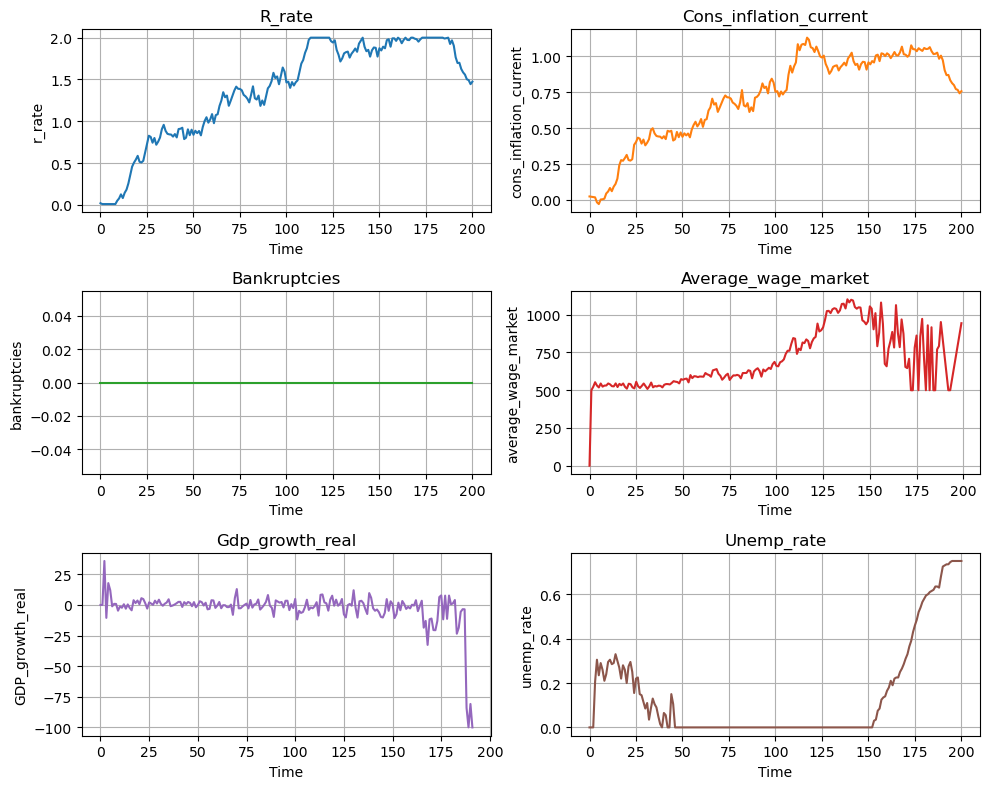

(-5.0, 5.0)

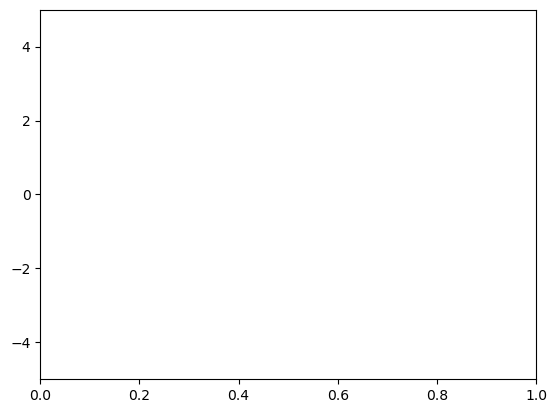

In [125]:
plot_columns(3, f"{path}\summary_plot_1_{test}",
 bank, "r_rate", 
 bank, "cons_inflation_current",
  pboard, "bankruptcies",
# pboard, "unemp_rate",
pboard, "average_wage_market", 
economy, "GDP_growth_real",
pboard, "unemp_rate")

plt.ylim(-5, 5)

/Users/ayman/Documents/miniconda3/envs/3dna/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ayman/Documents/miniconda3/envs/3dna/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ayman/Documents/miniconda3/envs/3dna/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ayman/Documents/miniconda3/envs/3dna/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning

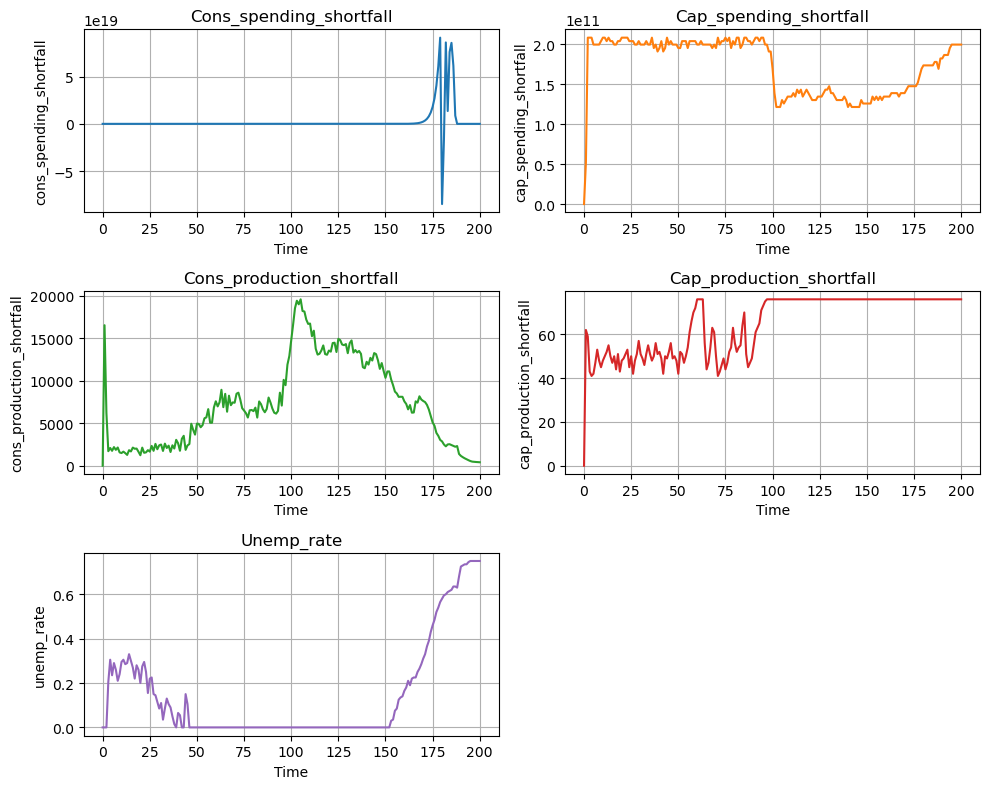

In [126]:
plot_columns(3, f"{path}\shortfalls_plot_{test}",
    economy, "cons_spending_shortfall",
    economy, "cap_spending_shortfall",
    pboard, "cons_production_shortfall",
    pboard, "cap_production_shortfall",
    pboard, "unemp_rate"
)

Plot histograms

Worker income distribution

/Users/ayman/Documents/miniconda3/envs/3dna/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ayman/Documents/miniconda3/envs/3dna/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ayman/Documents/miniconda3/envs/3dna/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ayman/Documents/miniconda3/envs/3dna/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning

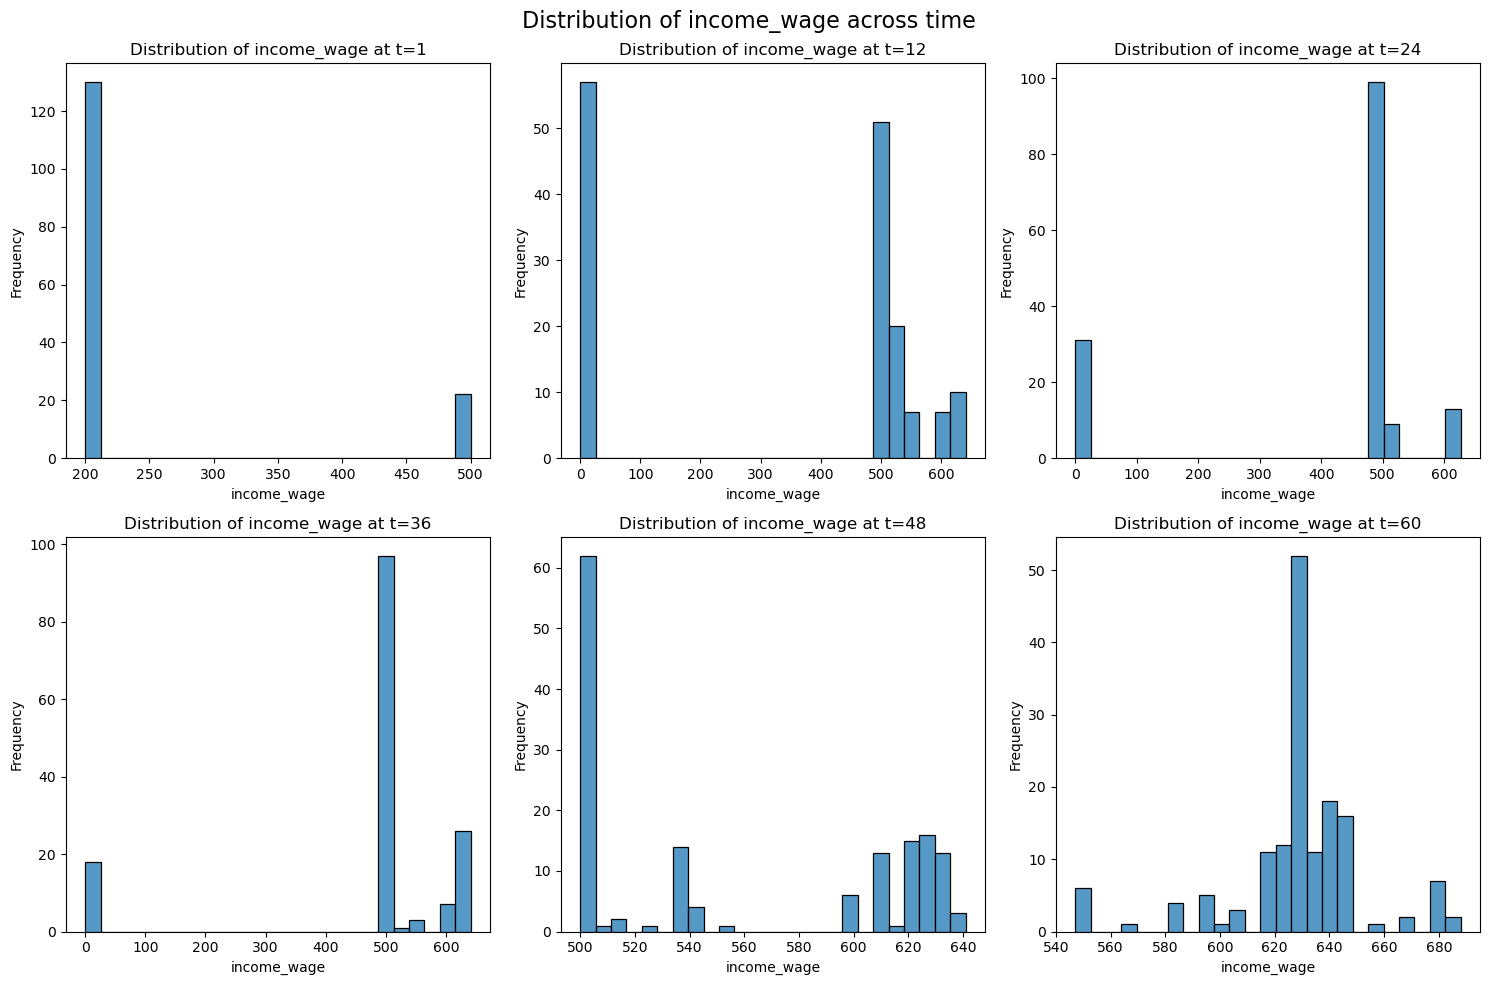

[{'date': 1,
  'mean': 243.42105263157896,
  'std': 105.89952293483233,
  'min': 200.0,
  'max': 500.0},
 {'date': 12,
  'mean': 331.3355263157895,
  'std': 259.7940841257572,
  'min': 0.0,
  'max': 641.0},
 {'date': 24,
  'mean': 409.07894736842104,
  'std': 210.36935434900153,
  'min': 0.0,
  'max': 627.0},
 {'date': 36,
  'mean': 468.0986842105263,
  'std': 178.98591308913097,
  'min': 0.0,
  'max': 641.0},
 {'date': 48,
  'mean': 559.0328947368421,
  'std': 57.754150994780595,
  'min': 500.0,
  'max': 641.0},
 {'date': 60,
  'mean': 628.8092105263158,
  'std': 25.782517191889674,
  'min': 547.0,
  'max': 688.0}]

In [127]:
analyze_distribution(
    f"{path}\worker_income_distribution_{test}",
households_workers, 'income_wage', [1,12,24,36,48,60])

Firm sizes

In [128]:
"""analyze_distribution(
    f"{path}\cons_firm_size_distribution_{test}",
    cons_firms, 'n_employees', [0,12,24,36,48,60])"""

'analyze_distribution(\n    f"{path}\\cons_firm_size_distribution_{test}",\n    cons_firms, \'n_employees\', [0,12,24,36,48,60])'

In [129]:
"""analyze_distribution(
     f"{path}\cap_firm_size_distribution_{test}",
     cap_firms, 'n_employees', [0,12,24,36,48,60])"""

'analyze_distribution(\n     f"{path}\\cap_firm_size_distribution_{test}",\n     cap_firms, \'n_employees\', [0,12,24,36,48,60])'

#### Interesting composite plots

Interesting Economic Curves

Plotting the Phillips curve

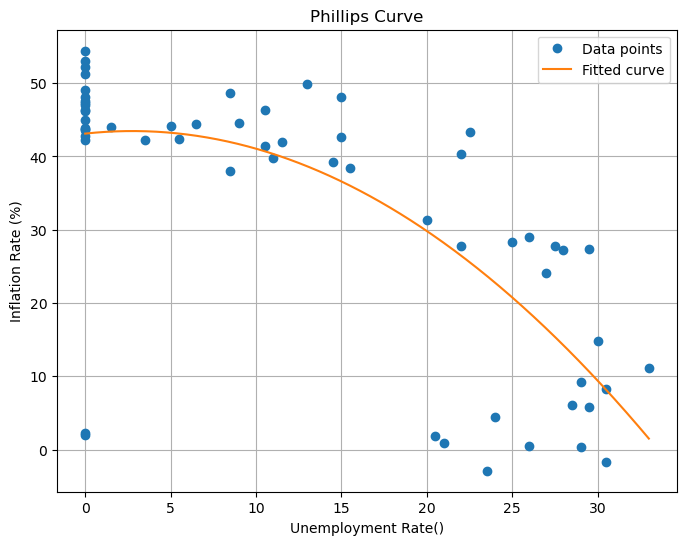

In [130]:
start_time = 0
end_time = 60

df = pd.DataFrame({
    "Inflation Rate": bank.loc[(bank["date"] > start_time) & ((bank["date"] < end_time)), "cons_inflation_current"],
    "Unemployment Rate": pboard.loc[(pboard["date"] > start_time) & (pboard["date"] < end_time), "unemp_rate"]
})

# Fillter for low or high unemployment
df = df[(df["Unemployment Rate"] > -1) & ((df["Unemployment Rate"] < 1)) ]

# Filter for low or high inflation
df = df[(df["Inflation Rate"] > -1) & (df["Inflation Rate"] < 1) ]


df = df* 100

# Plotting the data for the phillips curve
plt.figure(figsize=(8, 6))
plt.plot(df["Unemployment Rate"], df["Inflation Rate"], 'o', label='Data points')
# Fit a degree-2 polynomial to the data
coefficients = np.polyfit(df["Unemployment Rate"], df["Inflation Rate"], 2)
poly = np.poly1d(coefficients)
x_values = np.linspace(min(df["Unemployment Rate"]), max(df["Unemployment Rate"]), 500)
y_values = poly(x_values)
plt.plot(x_values, y_values, '-', label='Fitted curve')
plt.xlabel('Unemployment Rate()')
plt.ylabel('Inflation Rate (%)')
plt.title('Phillips Curve')
plt.grid(True)
plt.legend()


plt.savefig(f"{path}\phillips_curve_{test}.png", dpi=600)

plt.show()



#### Plotting the Beveridge curve

<Figure size 800x600 with 0 Axes>

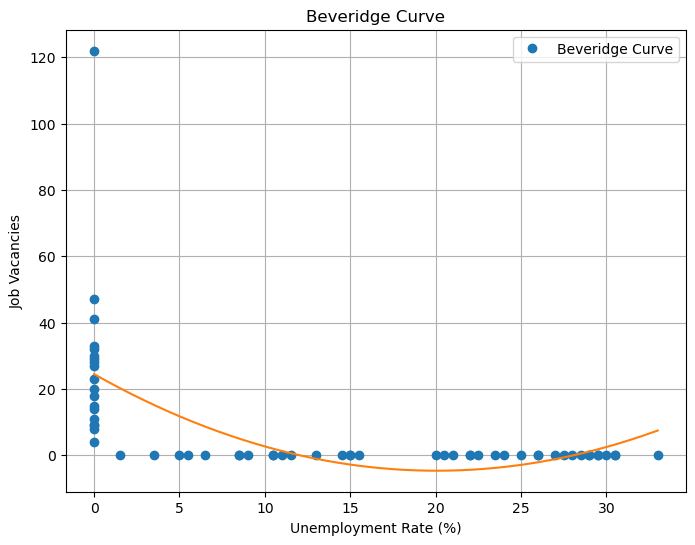

In [131]:
plt.figure(figsize=(8, 6))

start_time = 0
end_time = 60

df = pd.DataFrame({
    "Job Vacancies": pboard.loc[(pboard["date"] > start_time) & (pboard["date"] < end_time), "n_active_job_postings"],
    "Unemployment Rate": pboard.loc[(pboard["date"] > start_time) & (pboard["date"] < end_time), "unemp_rate"],
})

# Filter to show the best fit


# Fillter for low or high unemployment
df = df[(df["Unemployment Rate"] >= 0) & ((df["Unemployment Rate"] < 1)) ]

# Filter for low or high vacancies
df = df[(df["Job Vacancies"] >= 0) & (df["Job Vacancies"] < 200000) ]


df["Unemployment Rate"] = df["Unemployment Rate"] * 100

plt.figure(figsize=(8, 6))
plt.plot(df["Unemployment Rate"], df["Job Vacancies"], 'o', label='Beveridge Curve')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Job Vacancies')
plt.title('Beveridge Curve')
plt.legend()
plt.grid(True)

# Fit a degree-2 polynomial to the data
coefficients = np.polyfit(df["Unemployment Rate"], df["Job Vacancies"], 2)
poly = np.poly1d(coefficients)
# plot the fitted polynomial
x_values = np.linspace(min(df["Unemployment Rate"]), max(df["Unemployment Rate"]), 500)
y_values = poly(x_values)
plt.plot(x_values, y_values, '-', label='Fitted curve')




plt.savefig(f"{path}\Beveridge_curve_{test}.png", dpi=600)

plt.show()


Lorenz curve

In [132]:
"""date = 60

households["income"] = households["income_wage"] + households["income_dividend"] + households["income_unemployment_benefit"]
income_column = "income"
savings_column = "savings"

#df = households_workers[households_workers["date"] == 10][[income_column, "savings"]]

df = households[households["date"] == date][[income_column, savings_column]]


df = df.sort_values(by=income_column)

# Calculate the cumulative proportion of individuals and income
df['cumulative_count'] = np.linspace(0., 1., len(df))
df['cumulative_income'] = df[income_column].cumsum() / df[income_column].sum()
df["cumulative_savings"] = df[savings_column].cumsum() / df[savings_column].sum()


# Calculate the Gini coefficient
area_under_lorenz_curve = np.trapz(df['cumulative_income'], df['cumulative_count'])
area_under_perfect_equality_line = np.trapz(df['cumulative_count'], df['cumulative_count'])
gini_coefficient = 1 - 2 * (area_under_lorenz_curve - 0.5)
print(f'Gini Coefficient of income: {gini_coefficient:.2f}')



# Plot the Lorenz curve for income
plt.figure(figsize=(8, 6))
plt.plot(df['cumulative_count'], df['cumulative_income'], label='Lorenz curve')
plt.plot([0, 1], [0, 1], color='k', linestyle='--', label='Line of perfect income equality')
plt.xlabel('Cumulative proportion of individuals')
plt.ylabel('Cumulative proportion of income')
plt.title(f'Lorenz Curve for Income of all Households at t = {date} Gini Coefficient = {gini_coefficient:.2f}')
plt.legend()
plt.grid(True)

plt.savefig(f"{path}\lorenz_curve_income_t_{date}_{test}.png", dpi=600)
plt.show()


# Calculate the Gini coefficient for savings
area_under_lorenz_curve = np.trapz(df['cumulative_savings'], df['cumulative_count'])
area_under_perfect_equality_line = np.trapz(df['cumulative_count'], df['cumulative_count'])
gini_coefficient = 1 - 2 * (area_under_lorenz_curve - 0.5)
print(f'Gini Coefficient of wealth: {gini_coefficient:.2f}')

# Plot the Lorenz curve for savings
plt.figure(figsize=(8, 6))
plt.plot(df['cumulative_count'], df['cumulative_savings'], label='Lorenz curve')
plt.plot([0, 1], [0, 1], color='k', linestyle='--', label='Line of perfect wealth equality')
plt.xlabel('Cumulative proportion of individuals')
plt.ylabel('Cumulative proportion of savings')
plt.title(f'Lorenz Curve for Wealth of all Households at t= {date}, Gini Coefficient = {gini_coefficient:.2f}')
plt.legend()
plt.grid(True)
plt.savefig(f"{path}\lorenz_curve_savings_t_{date}_{test}.png", dpi=600)
plt.show()
"""




'date = 60\n\nhouseholds["income"] = households["income_wage"] + households["income_dividend"] + households["income_unemployment_benefit"]\nincome_column = "income"\nsavings_column = "savings"\n\n#df = households_workers[households_workers["date"] == 10][[income_column, "savings"]]\n\ndf = households[households["date"] == date][[income_column, savings_column]]\n\n\ndf = df.sort_values(by=income_column)\n\n# Calculate the cumulative proportion of individuals and income\ndf[\'cumulative_count\'] = np.linspace(0., 1., len(df))\ndf[\'cumulative_income\'] = df[income_column].cumsum() / df[income_column].sum()\ndf["cumulative_savings"] = df[savings_column].cumsum() / df[savings_column].sum()\n\n\n# Calculate the Gini coefficient\narea_under_lorenz_curve = np.trapz(df[\'cumulative_income\'], df[\'cumulative_count\'])\narea_under_perfect_equality_line = np.trapz(df[\'cumulative_count\'], df[\'cumulative_count\'])\ngini_coefficient = 1 - 2 * (area_under_lorenz_curve - 0.5)\nprint(f\'Gini Coeffi

## Sector data

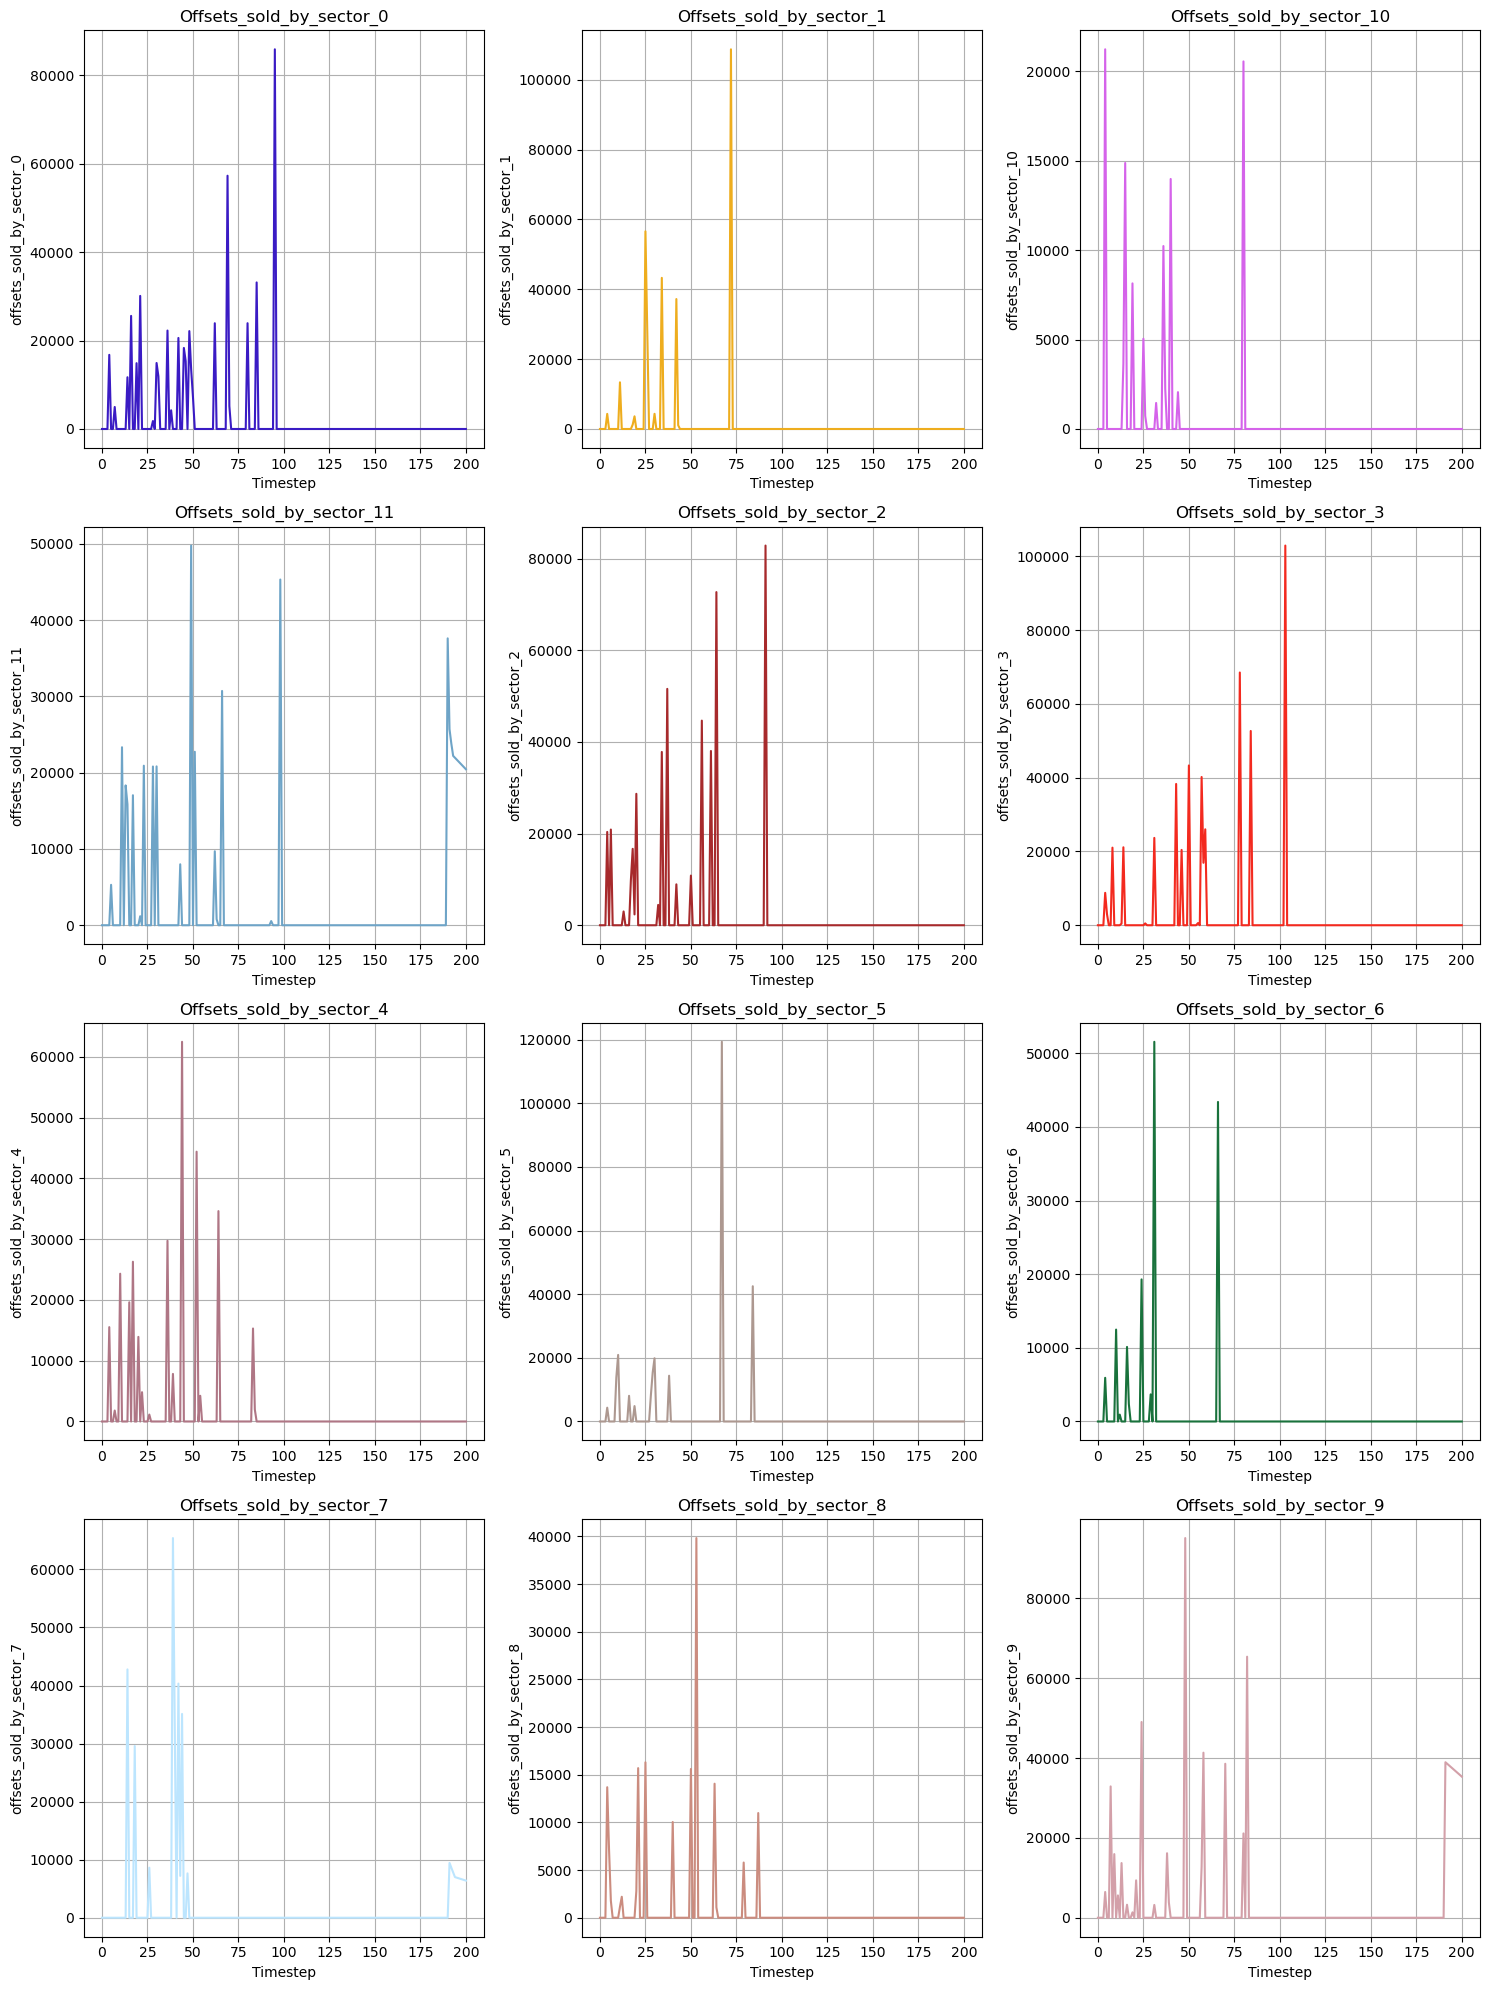

In [133]:

plot_values_incl(f"{path}\sector_offsets_sold_{test}", sector_data,t, ["offsets_sold_"])

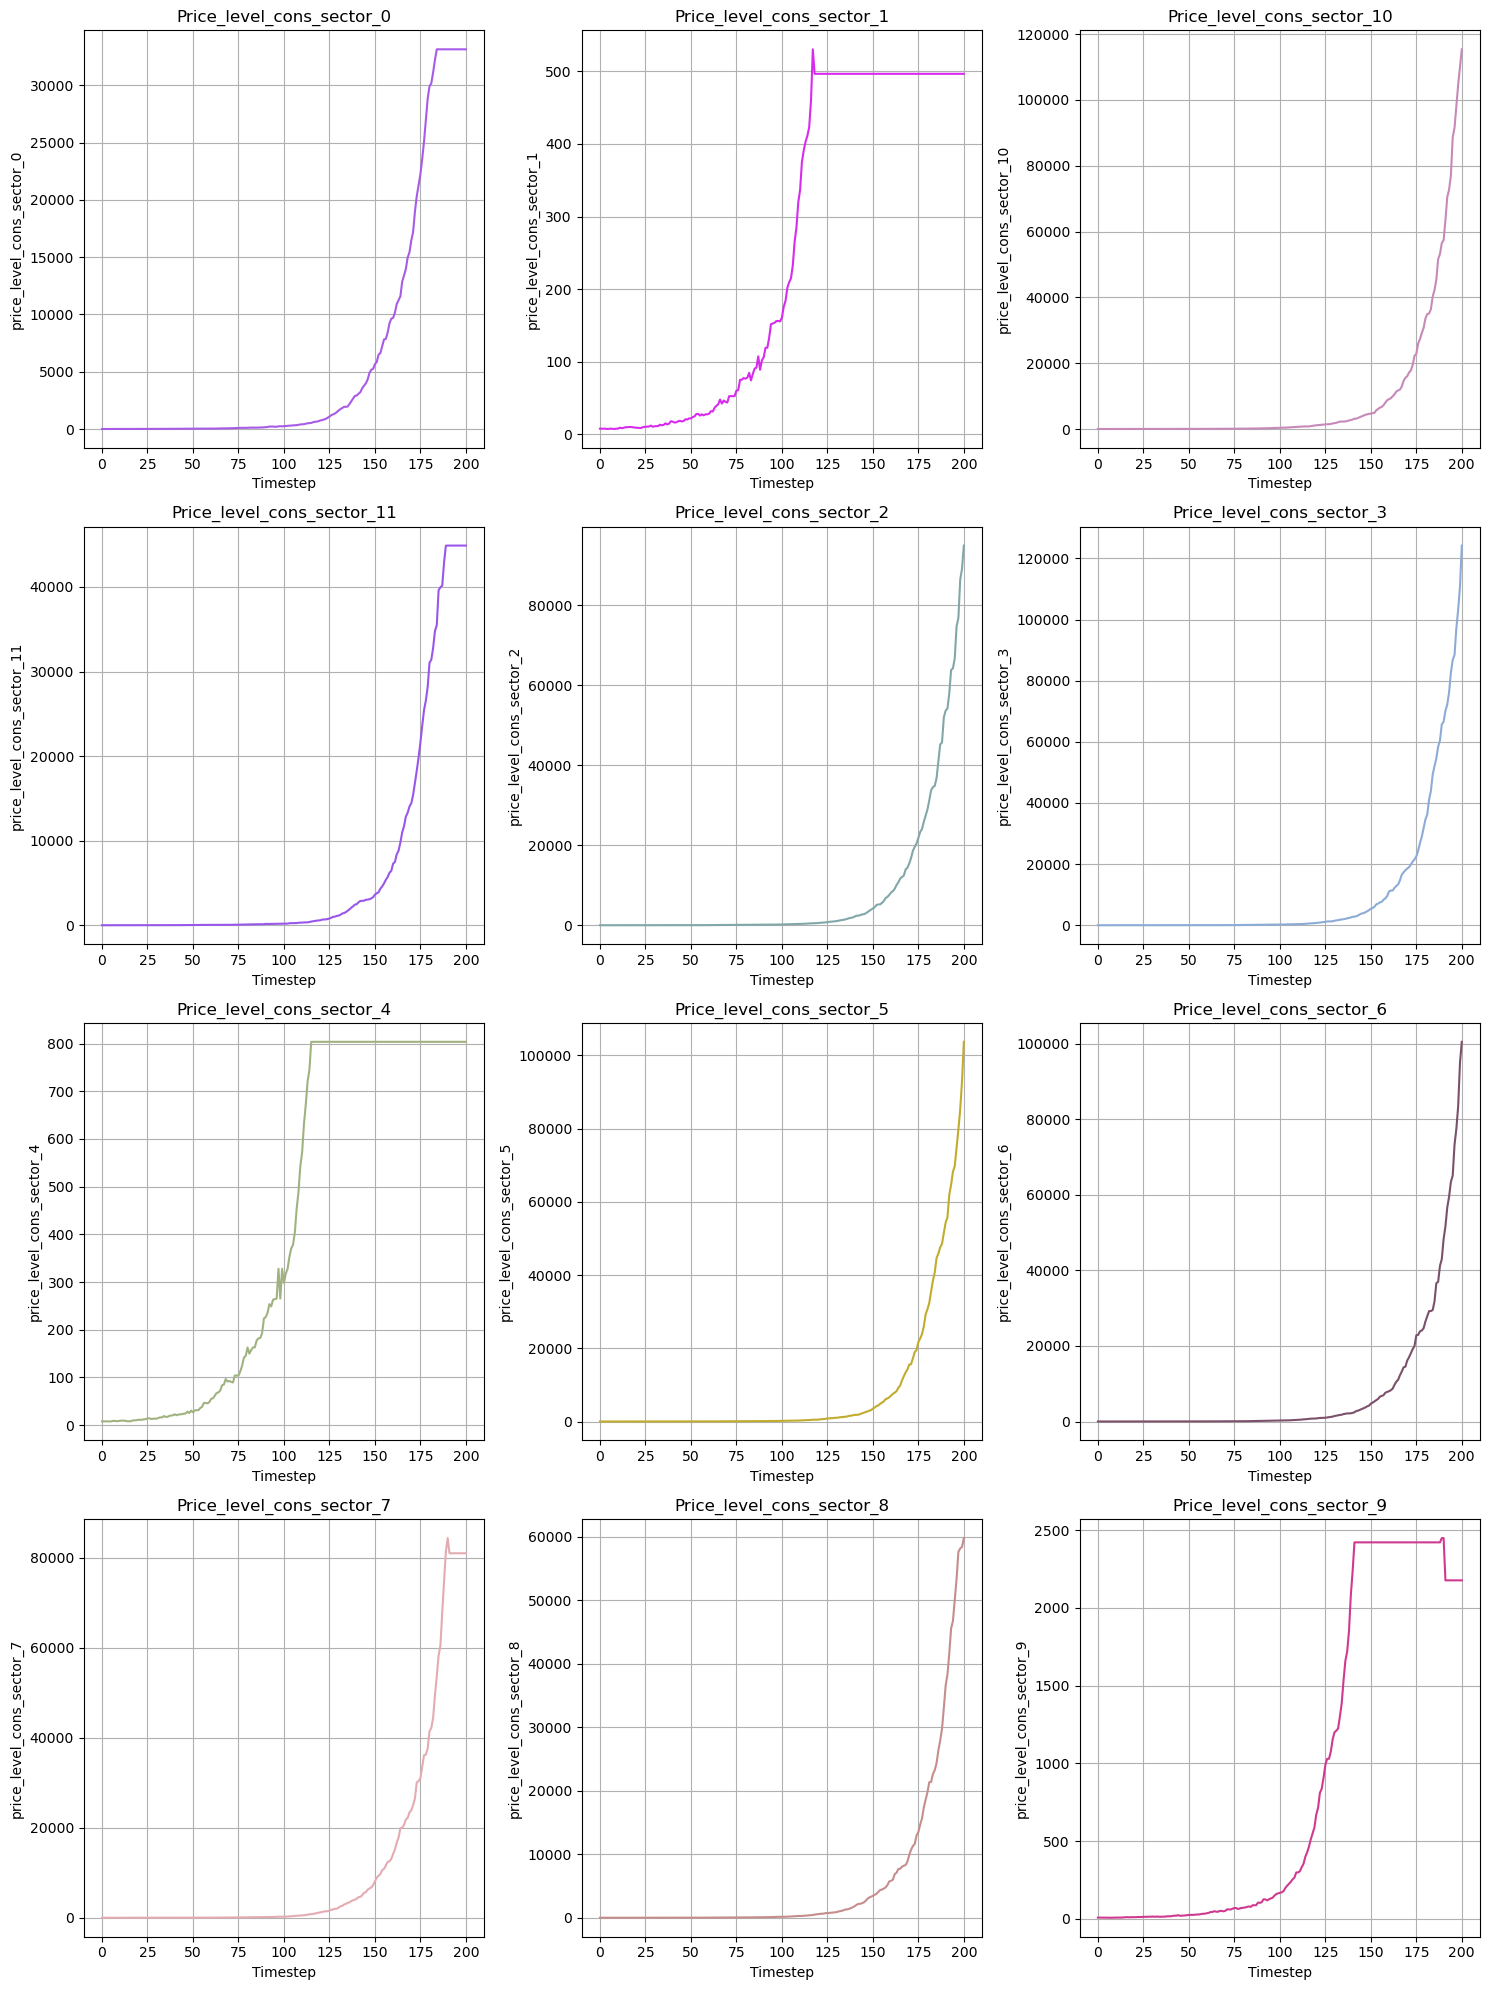

In [134]:

plot_values_incl(f"{path}\sector_price_level{test}", sector_data,t, ["price_level_"])

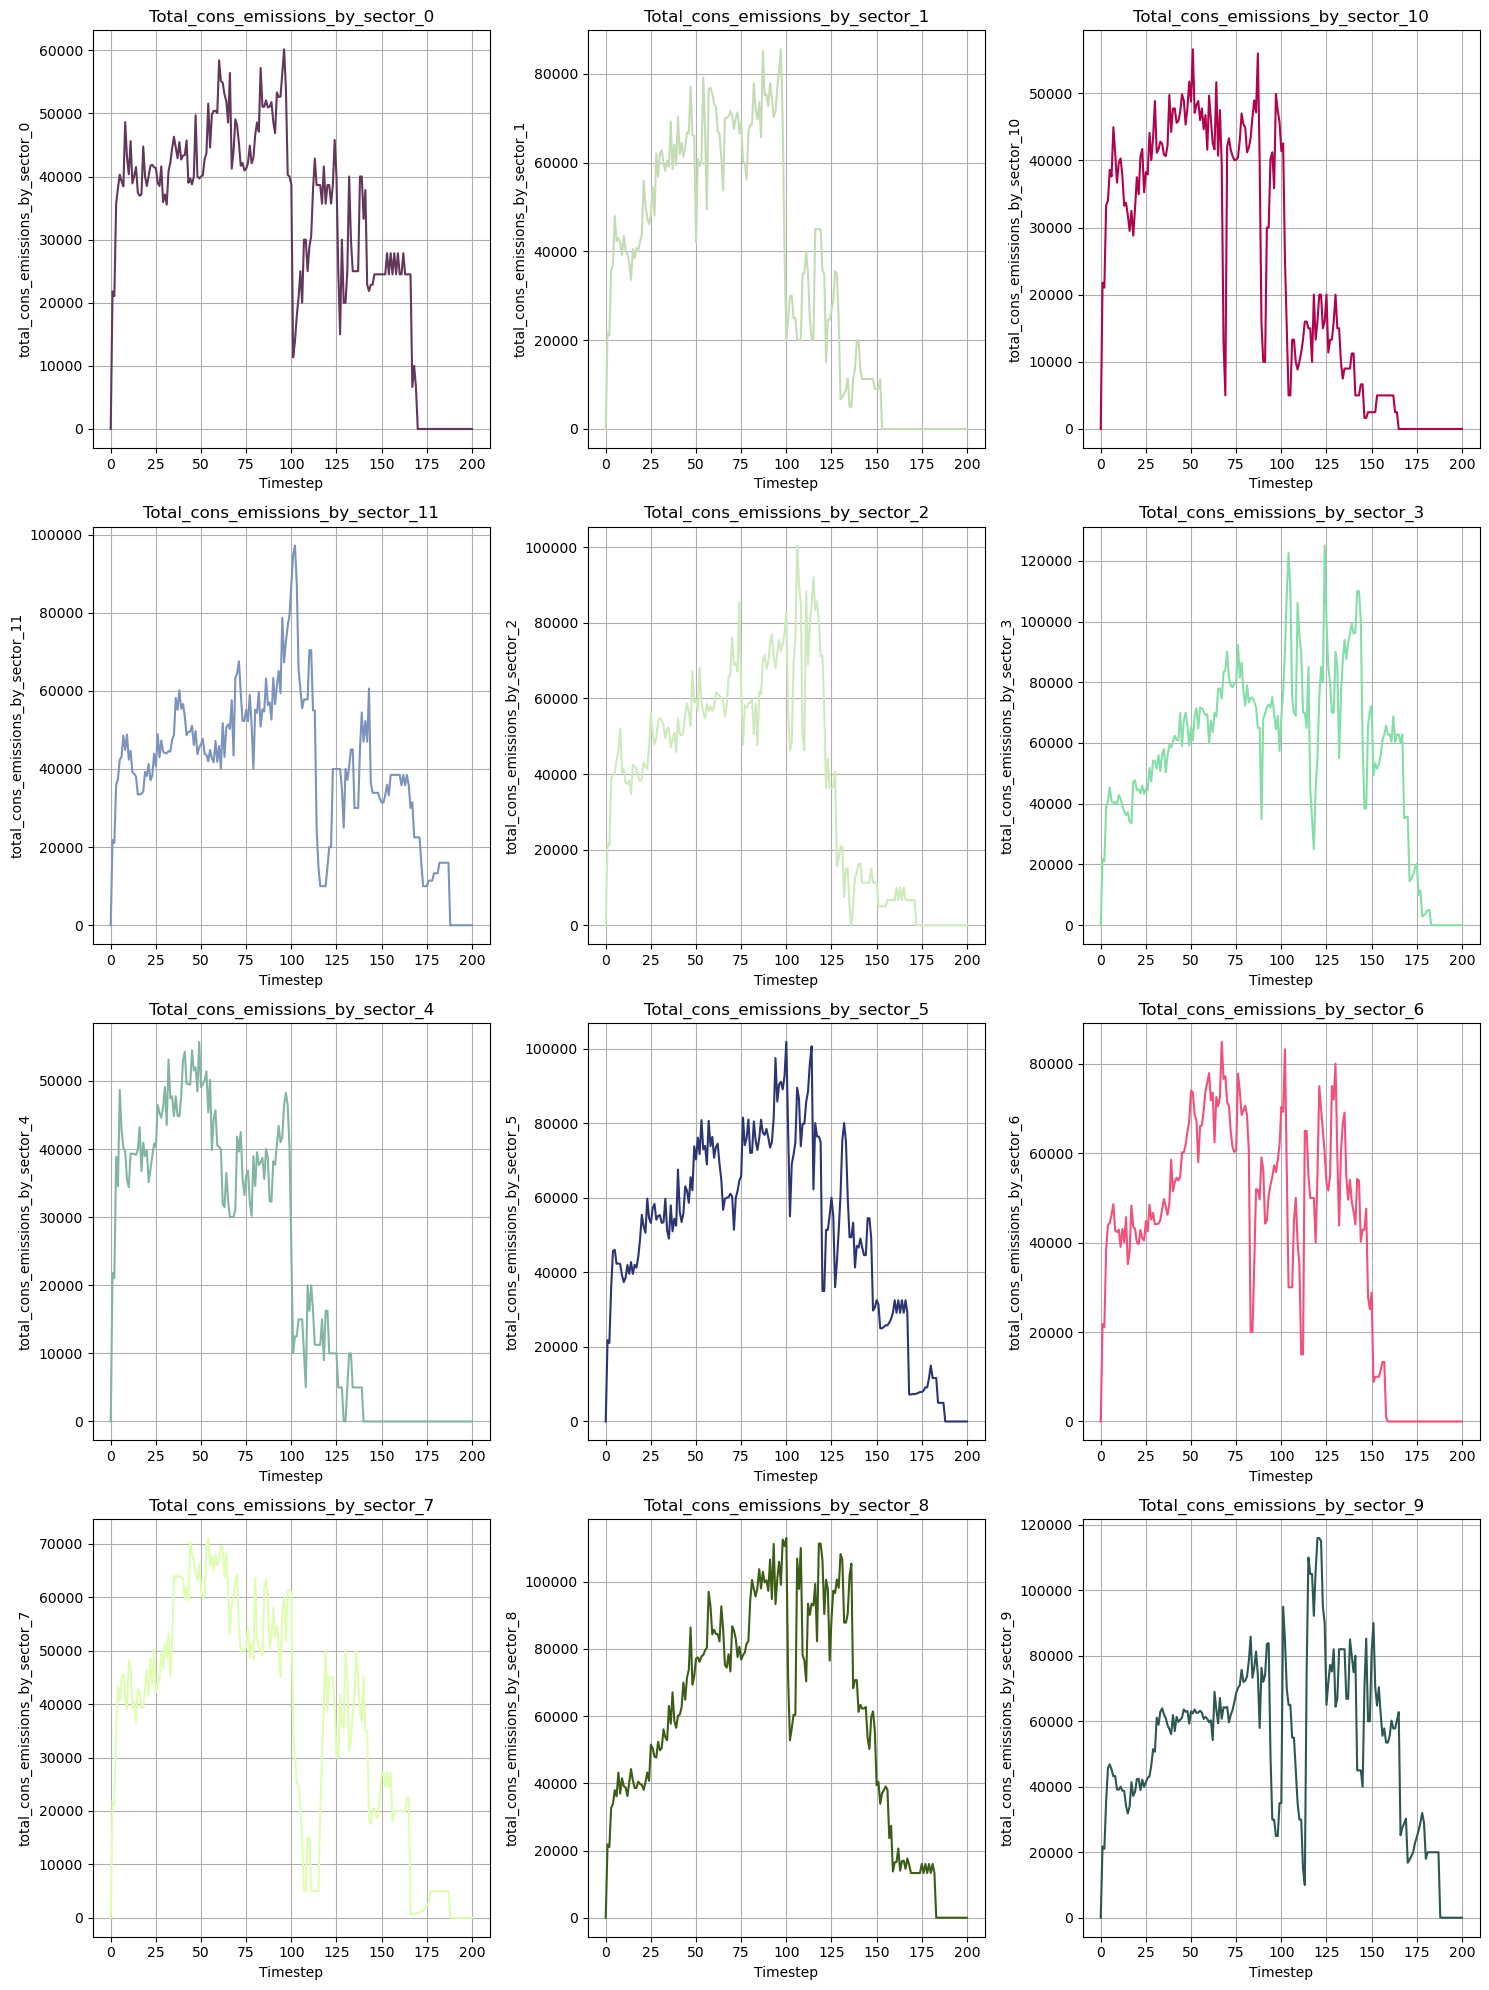

In [135]:

plot_values_incl(f"{path}\sector_total_emissions_{test}", sector_data,t, ["total_cons_emissions_"])

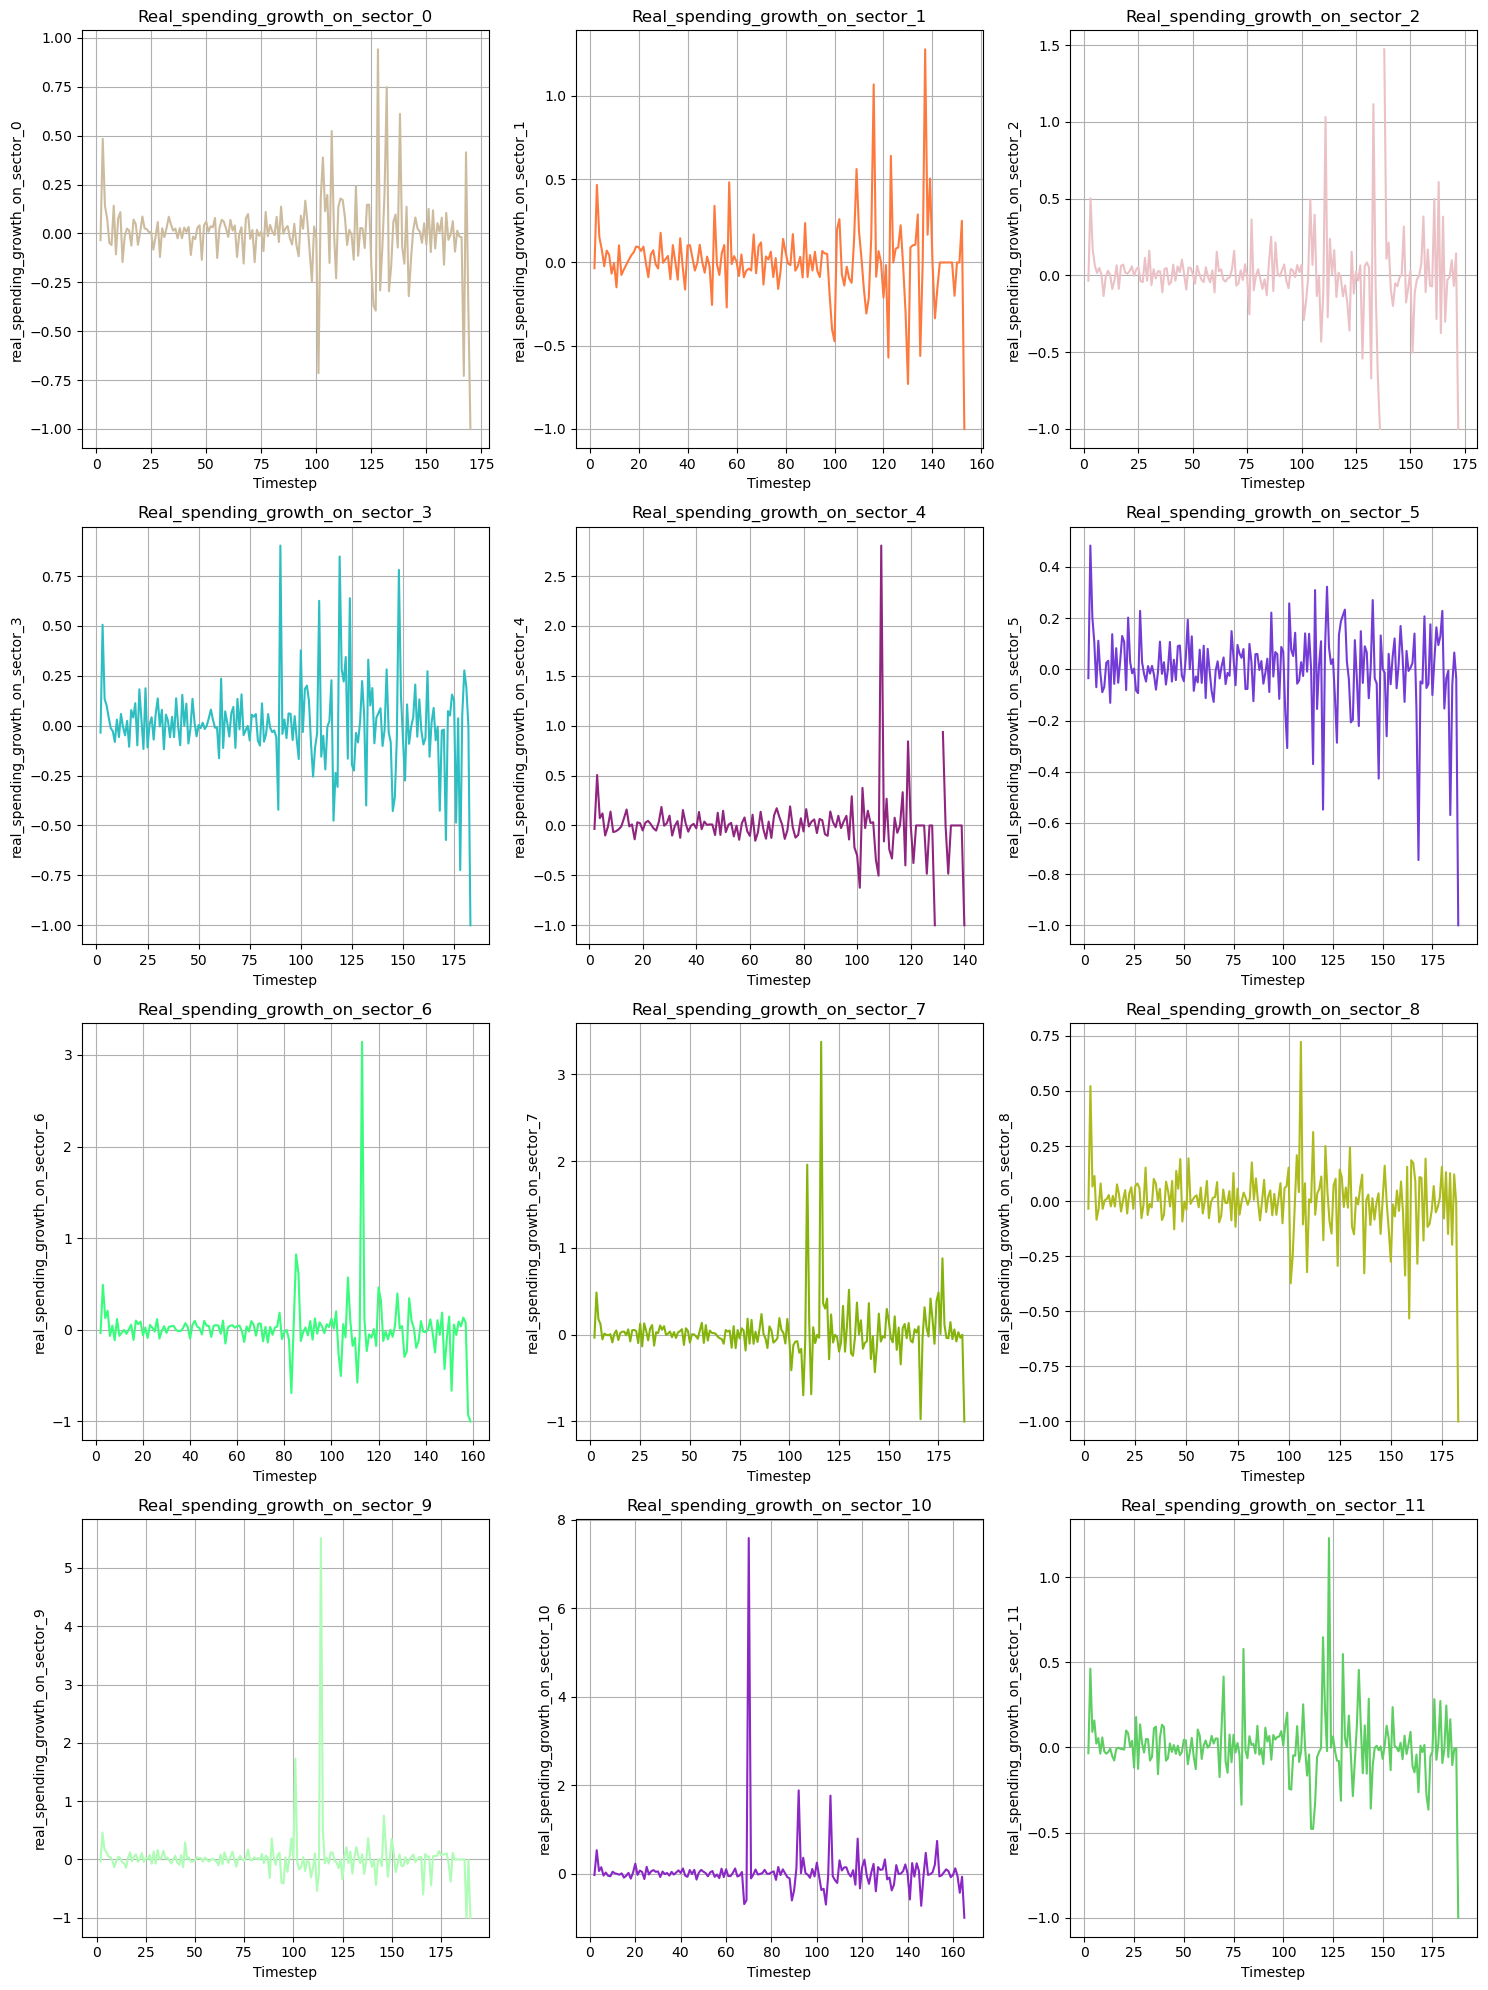

In [136]:

plot_values_incl(f"{path}\sector_spending_growth_{test}", sector_data,t, ["real_spending_growth"])